# Binary logistic regression with $l_1$

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from optax.losses import safe_softmax_cross_entropy as cros_entr
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

@jit
def logistic_loss(w, X, y, lam=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + lam * jnp.linalg.norm(w, ord=1)

def generate_problem(m=1000, n=300, lam=1):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//(20), random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, y_train, X_test, y_test

def compute_optimal(X, y, lam):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + lam * cp.norm(w, 1))
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

@jit
def compute_accuracy(w, X, y):
    # Compute predicted probabilities using the logistic (sigmoid) function
    preds_probs = jax.nn.sigmoid(X @ w)
    # Convert probabilities to class predictions: 0 if p < 0.5, else 1
    preds = jnp.where(preds_probs < 0.5, 0, 1)
    # Calculate accuracy as the average of correct predictions
    accuracy = jnp.mean(preds == y)
    return accuracy

# @jit # Uncomment this if you want to compile this function with JAX for speed improvements
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam):
    f = lambda w: logistic_loss(w, X_train, y_train, lam)
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
        "sparsity": [jnp.mean(jnp.abs(x) < 1e-5) for x in trajectory]  # Calculating sparsity
    }
    return metrics

def gradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, lam=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, lam)
    iter_start = time.time()
    for i in range(num_iters):
        grad_val = grad(f)(w)
        if learning_rate == "linesearch":
            # Simple line search implementation
            phi = lambda alpha: f(w - alpha*grad_val)
            result = minimize_scalar(fun=phi, 
                                     bounds=(1e-3, 2e2)
                              )
            step_size = result.x
        else:
            step_size = learning_rate
        w -= step_size * grad_val
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

def subgradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, lam)

    iter_start = time.time()
    for i in range(num_iters):
        grad_val = grad(f)(w)
        subgrad_val = grad_val + lam * jnp.sign(w)
        w -= learning_rate * subgrad_val
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times


def soft_thresholding(x, kappa):
    return jnp.sign(x) * jnp.maximum(jnp.abs(x) - kappa, 0)

def proximal_gradient_method(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, lam) - lam * jnp.linalg.norm(w, ord=1)

    iter_start = time.time()
    for i in range(num_iters):
        grad_val = grad(f)(w)
        w = soft_thresholding(w - learning_rate * grad_val, learning_rate * lam)
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

def accelerated_proximal_gradient_method(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    w = w_0
    z = w_0
    t = 1.0
    trajectory = [w_0]
    times = [0]
    f = lambda w: logistic_loss(w, X, y, lam) - lam * jnp.linalg.norm(w, ord=1)

    iter_start = time.time()
    for i in range(num_iters):
        w_prev = w
        grad_val = grad(f)(z)
        w = soft_thresholding(z - learning_rate * grad_val, learning_rate * lam)
        t_next = (1 + jnp.sqrt(1 + 4 * t**2)) / 2
        z = w + ((t - 1) / t_next) * (w - w_prev)
        t = t_next

        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    
    return trajectory, times

def admm_logistic_regression(X, y, lam=1, rho=1, num_iters=100):
    m, n = X.shape
    w = jnp.zeros(n)
    z = jnp.zeros(n)
    u = jnp.zeros(n)
    trajectory = [w]
    times = [0]

    I = jnp.eye(n)  # Identity matrix for w-update
    H = (X.T @ X) / m + rho * I  # Hessian of the quadratic approximation of the augmented Lagrangian
    H_inv = jnp.linalg.inv(H)  # Pre-compute the inverse Hessian

    iter_start = time.time()
    for i in range(num_iters):
        # w-update (via a single Newton-Raphson step for logistic regression)
        grad_w = (X.T @ (jax.nn.sigmoid(X @ w) - y)) / m + rho * (w - z + u)
        w = w - H_inv @ grad_w

        # z-update (soft-thresholding)
        z = soft_thresholding(w + u, lam / rho)

        # u-update (dual update)
        u = u + (w - z)

        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    
    return trajectory, times


def run_experiments(params):
    lam = params["lam"]
    m, n = params["m"], params["n"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem(m, n, lam)
    n_features = X_train.shape[1]  # Number of features
    params["n_features"] = n_features
    
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, ))
    x_star, f_star = compute_optimal(X_train, y_train, lam)

    for method in methods:
        if method["method"] == "Subgrad":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = subgradient_descent(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)
        elif method["method"] == "Proximal":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = proximal_gradient_method(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)
        elif method["method"] == "Accelerated Proximal":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = accelerated_proximal_gradient_method(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)
        elif method["method"] == "ADMM":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = admm_logistic_regression(X_train, y_train, rho=learning_rate, num_iters=iterations, lam=lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    lam = params["lam"]
    plt.suptitle(f"Convex binary logistic regression. lam={lam}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method + f" sparsity {metrics['sparsity'][-1]:.3f}")
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{lam}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

In [196]:
params = {
    "lam": 2e-2,
    "m": 400,
    "n": 40,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 5e0,
            "iterations": 75,
        },
        {
            "method": "Proximal",
            "learning_rate": 12,
            "iterations": 75,
        },
        # {
        #     "method": "Accelerated Proximal",
        #     "learning_rate": 12,
        #     "iterations": 75,
        # },
    ]
}

results, params = run_experiments(params)

/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


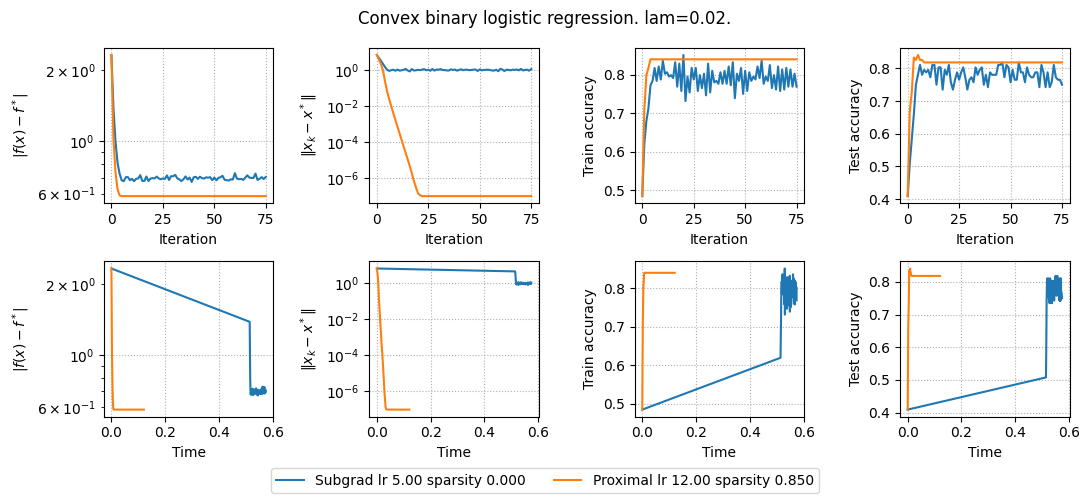

In [197]:
plot_results(results, params)

/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


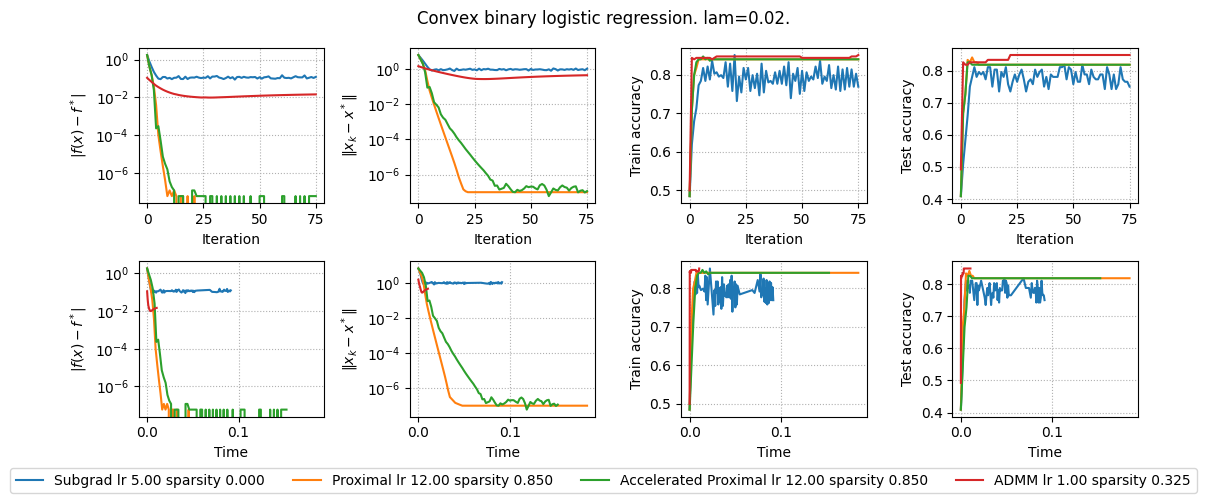

In [192]:
params = {
    "lam": 2e-2,
    "m": 400,
    "n": 40,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 5,
            "iterations": 75,
        },
        {
            "method": "Proximal",
            "learning_rate": 12,
            "iterations": 75,
        },
        {
            "method": "Accelerated Proximal",
            "learning_rate": 12,
            "iterations": 75,
        },
        {
            "method": "ADMM",
            "learning_rate": 1,
            "iterations": 75,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)